In [1]:
library(tidyverse)
library(arrow)
library(dbplyr)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘arrow’


The following object is masked from ‘package:lubridate’:

    duration


The following object is masked from ‘package:utils’:

    timestamp



Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




# Pull data

In [2]:
# General EHR DB connector
con <- DBI::dbConnect(
    RMariaDB::MariaDB(),
    host = "localhost",
    user = "mnz2108",
    dbname = "clinical_merge_v5_2022q1",
    password = read_file('mysql_password.txt') %>% str_squish
)

In [3]:
merged_df <- bind_rows(
    read_csv("onsides_compiled_table_wo_freq.csv", show_col_types = F) %>% 
        select(ingredients_rxcuis, pt_meddra_id) %>%
        separate_longer_delim("ingredients_rxcuis", delim = ',') %>%
        mutate(source="Japan"),
    read_csv("onsides_table_wo_freq.csv", show_col_types = F) %>% 
        select(ingredients_rxcuis, pt_meddra_id) %>%
        separate_longer_delim("ingredients_rxcuis", delim = ',') %>%
        mutate(source="UK"),
    read_csv("adverse_events_eu.csv", show_col_types = F) %>%
        filter(!is.na(pt_meddra_id)) %>%
        select(ingredients_rxcuis = ingredient_codes, pt_meddra_id) %>%
        separate_longer_delim("ingredients_rxcuis", delim = ",") %>%
        mutate(source="EU"),
    con %>% 
        tbl(in_schema("effect_onsides_v02", "adverse_reactions")) %>%
        select(ingredients_rxcuis, pt_meddra_id) %>%
        distinct %>%
        mutate(source="US") %>%
        as_tibble %>%
        separate_longer_delim("ingredients_rxcuis", delim = ',')
) %>%
    mutate(
        ingredients_rxcuis = str_trim(ingredients_rxcuis),
        pt_meddra_id = as.character(pt_meddra_id)
    ) %>%
    filter(ingredients_rxcuis != "") %>%
    select(rxnorm_concept_code=ingredients_rxcuis, meddra_pt_concept_code=pt_meddra_id, source)

merged_df %>% write_parquet("merged_us_uk_japan_eu.parquet")

merged_df %>% head(2)

rxnorm_concept_code,meddra_pt_concept_code,source
<chr>,<chr>,<chr>
9873,10020751,Japan
9873,10007247,Japan


In [4]:
rxnorm_ids <- merged_df %>% distinct(rxnorm_concept_code) %>% pull

con %>% 
    tbl("concept") %>% 
    filter(vocabulary_id == "RxNorm", concept_code %in% rxnorm_ids) %>%
    select(rxnorm_concept_code=concept_code, rxnorm_concept_name=concept_name, rxnorm_concept_id=concept_id) %>%
    inner_join(tbl(con, "concept_relationship") %>% select(concept_id_1, concept_id_2), by = c("rxnorm_concept_id" = "concept_id_1")) %>%
    inner_join(tbl(con, "concept"), by = c("concept_id_2" = "concept_id")) %>%
    filter(vocabulary_id == "ATC", concept_class_id == "ATC 5th") %>%
    select(rxnorm_concept_code, rxnorm_concept_name, rxnorm_concept_id, atc_5_concept_id=concept_id_2, atc_5_concept_name=concept_name) %>%
    inner_join(tbl(con, "concept_ancestor"), by = c("atc_5_concept_id" = "descendant_concept_id")) %>%
    inner_join(tbl(con, "concept"), by = c("ancestor_concept_id" = "concept_id")) %>%
    filter(vocabulary_id == "ATC", concept_class_id == "ATC 1st") %>%
    select(
        rxnorm_concept_code, rxnorm_concept_name, rxnorm_concept_id, 
        atc_5_concept_id, atc_5_concept_name, 
        atc_1_concept_id=ancestor_concept_id, atc_1_concept_name=concept_name
    ) %>%
    as_tibble %>%
    write_parquet("rxnorm_atc5_atc1.parquet")

In [5]:
meddra_ids <- merged_df %>% distinct(meddra_pt_concept_code) %>% pull %>% as.character()

con %>% 
    tbl("concept") %>% 
    filter(vocabulary_id == "MedDRA", concept_code %in% meddra_ids) %>%
    select(meddra_pt_concept_code=concept_code, meddra_pt_concept_name=concept_name, meddra_pt_concept_id=concept_id) %>%
    inner_join(tbl(con, "concept_ancestor"), by = c("meddra_pt_concept_id" = "descendant_concept_id")) %>%
    inner_join(tbl(con, "concept"), by = c("ancestor_concept_id" = "concept_id")) %>%
    filter(vocabulary_id == "MedDRA", concept_class_id == "SOC") %>%
    select(
        meddra_pt_concept_code, meddra_pt_concept_name, meddra_pt_concept_id, 
        meddra_soc_concept_id=ancestor_concept_id, meddra_soc_concept_name=concept_name
    ) %>%
    as_tibble %>%
    write_parquet("meddra_pt_meddra_soc.parquet")

# Final merge

In [6]:
meddra_df <- read_parquet("meddra_pt_meddra_soc.parquet")
rxnorm_df <- read_parquet("rxnorm_atc5_atc1.parquet")
merged_df <- read_parquet("merged_us_uk_japan_eu.parquet")

full_df <- merged_df %>%
    inner_join(rxnorm_df, by = "rxnorm_concept_code", relationship = "many-to-many") %>%
    inner_join(meddra_df, by = "meddra_pt_concept_code", relationship = "many-to-many")

full_df %>% write_parquet("full_table_final.parquet")

full_df %>% head(2)

rxnorm_concept_code,meddra_pt_concept_code,source,rxnorm_concept_name,rxnorm_concept_id,atc_5_concept_id,atc_5_concept_name,atc_1_concept_id,atc_1_concept_name,meddra_pt_concept_name,meddra_pt_concept_id,meddra_soc_concept_id,meddra_soc_concept_name
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>
9873,10020751,Japan,sodium fluoride,19069022,1501789,"colecalciferol, combinations",21600001,ALIMENTARY TRACT AND METABOLISM,Hypersensitivity,36009711,36000000,Immune system disorders
9873,10020751,Japan,sodium fluoride,19069022,21600671,"lactic acid producing organisms, combinations; oral",21600001,ALIMENTARY TRACT AND METABOLISM,Hypersensitivity,36009711,36000000,Immune system disorders


# Analysis

1. How many ADRs per drug class (compare with UK/Japan)
2. How many drugs per ADR class (compare with UK/Japan)
3. How many connections from drug class to ADR class (comparing overlap vs UK)
4. Same but Japan
5. Number of ADRs per drug (US vs UK)
6. Number of ADRs per drug (US vs Japan)

In [7]:
full_df <- read_parquet("full_table_final.parquet")

In [8]:
plot_df <- full_df %>%
    mutate(
        source = source %>% factor(levels = c("US", "EU", "Japan", "UK")),
        atc_1_concept_name = atc_1_concept_name %>% str_to_sentence %>% factor,
        meddra_soc_concept_name = meddra_soc_concept_name %>% str_replace_all("disorders", "")
    )

## A

In [9]:
fig_a_df <- plot_df %>%
    group_by(source, atc_1_concept_id, atc_1_concept_name) %>%
    summarize(
        n_adrs = n_distinct(meddra_pt_concept_code),
        .groups = "drop"
    )

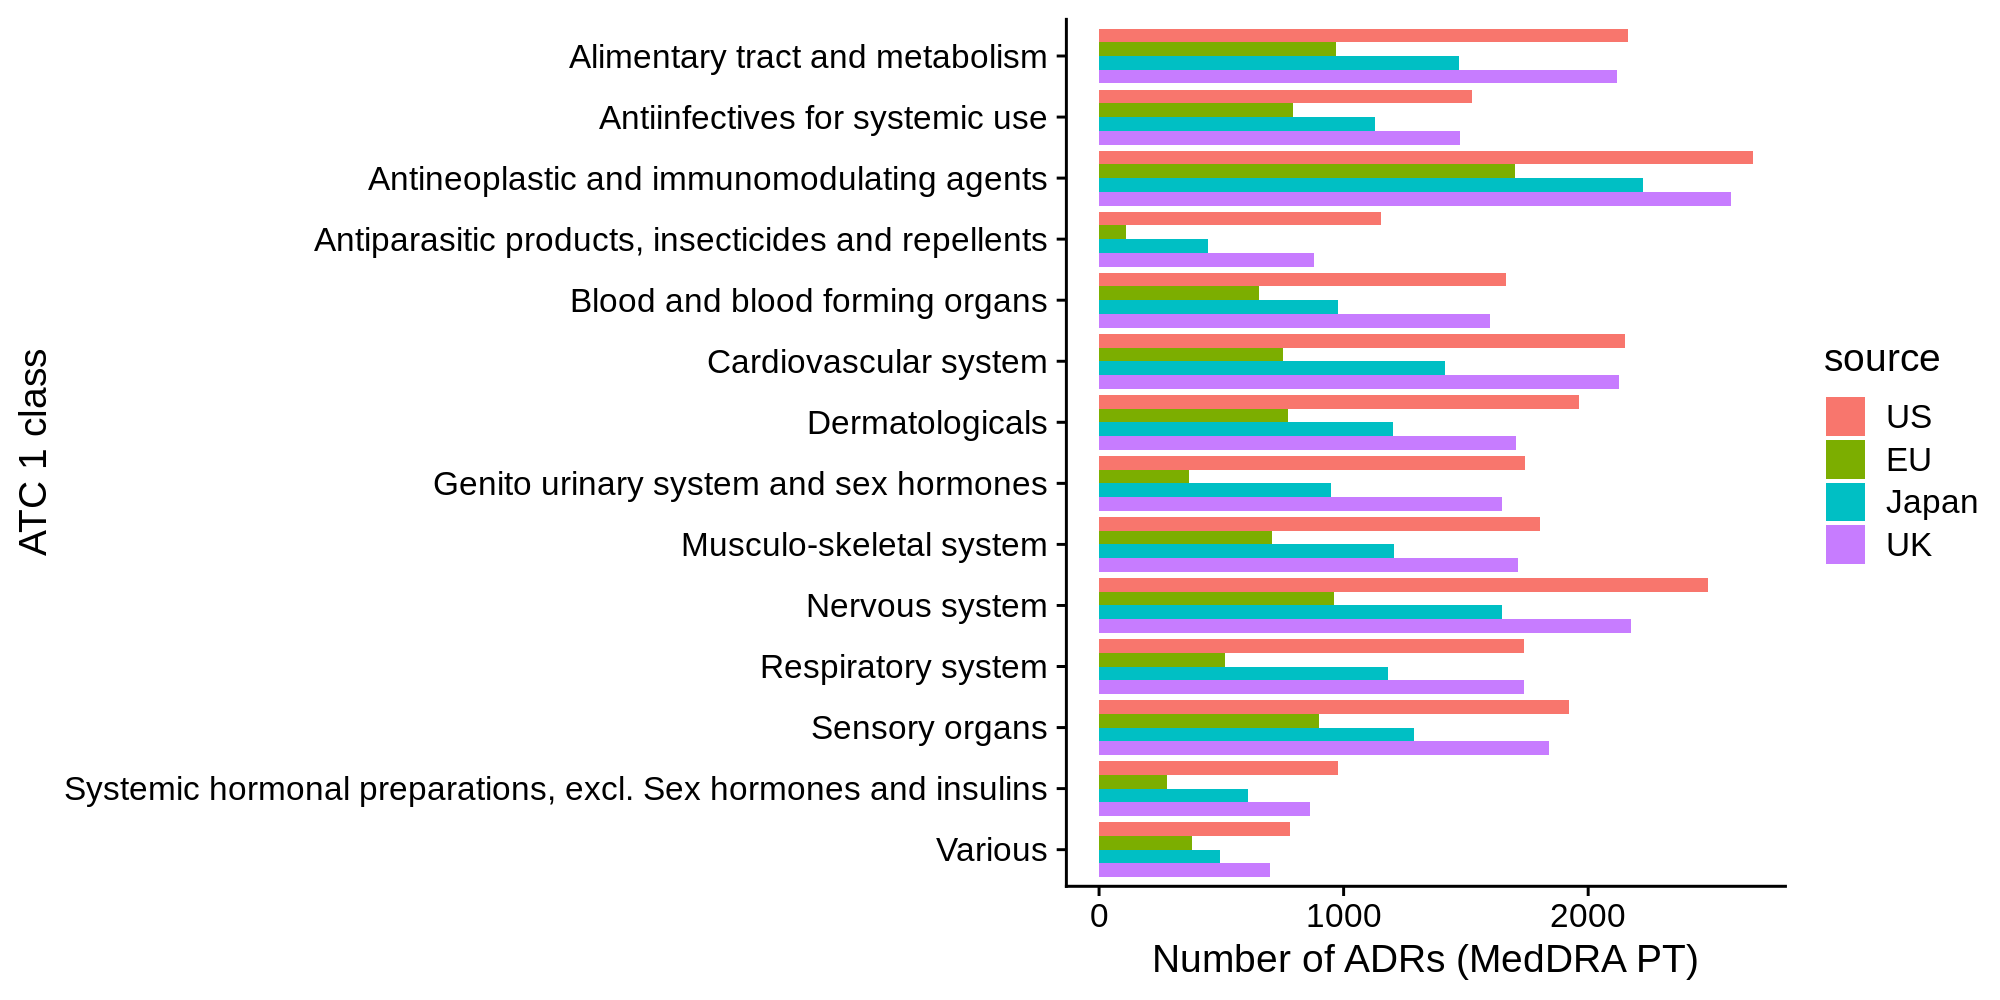

In [10]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200)

fig_a <- fig_a_df %>%
    mutate(atc_1_concept_name = atc_1_concept_name %>% fct_rev) %>%
    ggplot(aes(y = atc_1_concept_name, x = n_adrs, fill = source)) +
    geom_col(position = position_dodge2(reverse = T, padding = 0)) +
    xlab("Number of ADRs (MedDRA PT)") +
    ylab("ATC 1 class") +
    theme_cowplot()

fig_a

## B

In [11]:
fig_b_df <- plot_df %>%
    group_by(source, meddra_soc_concept_id, meddra_soc_concept_name) %>%
    summarize(
        n_ingredients = n_distinct(rxnorm_concept_code),
        .groups = "drop"
    )

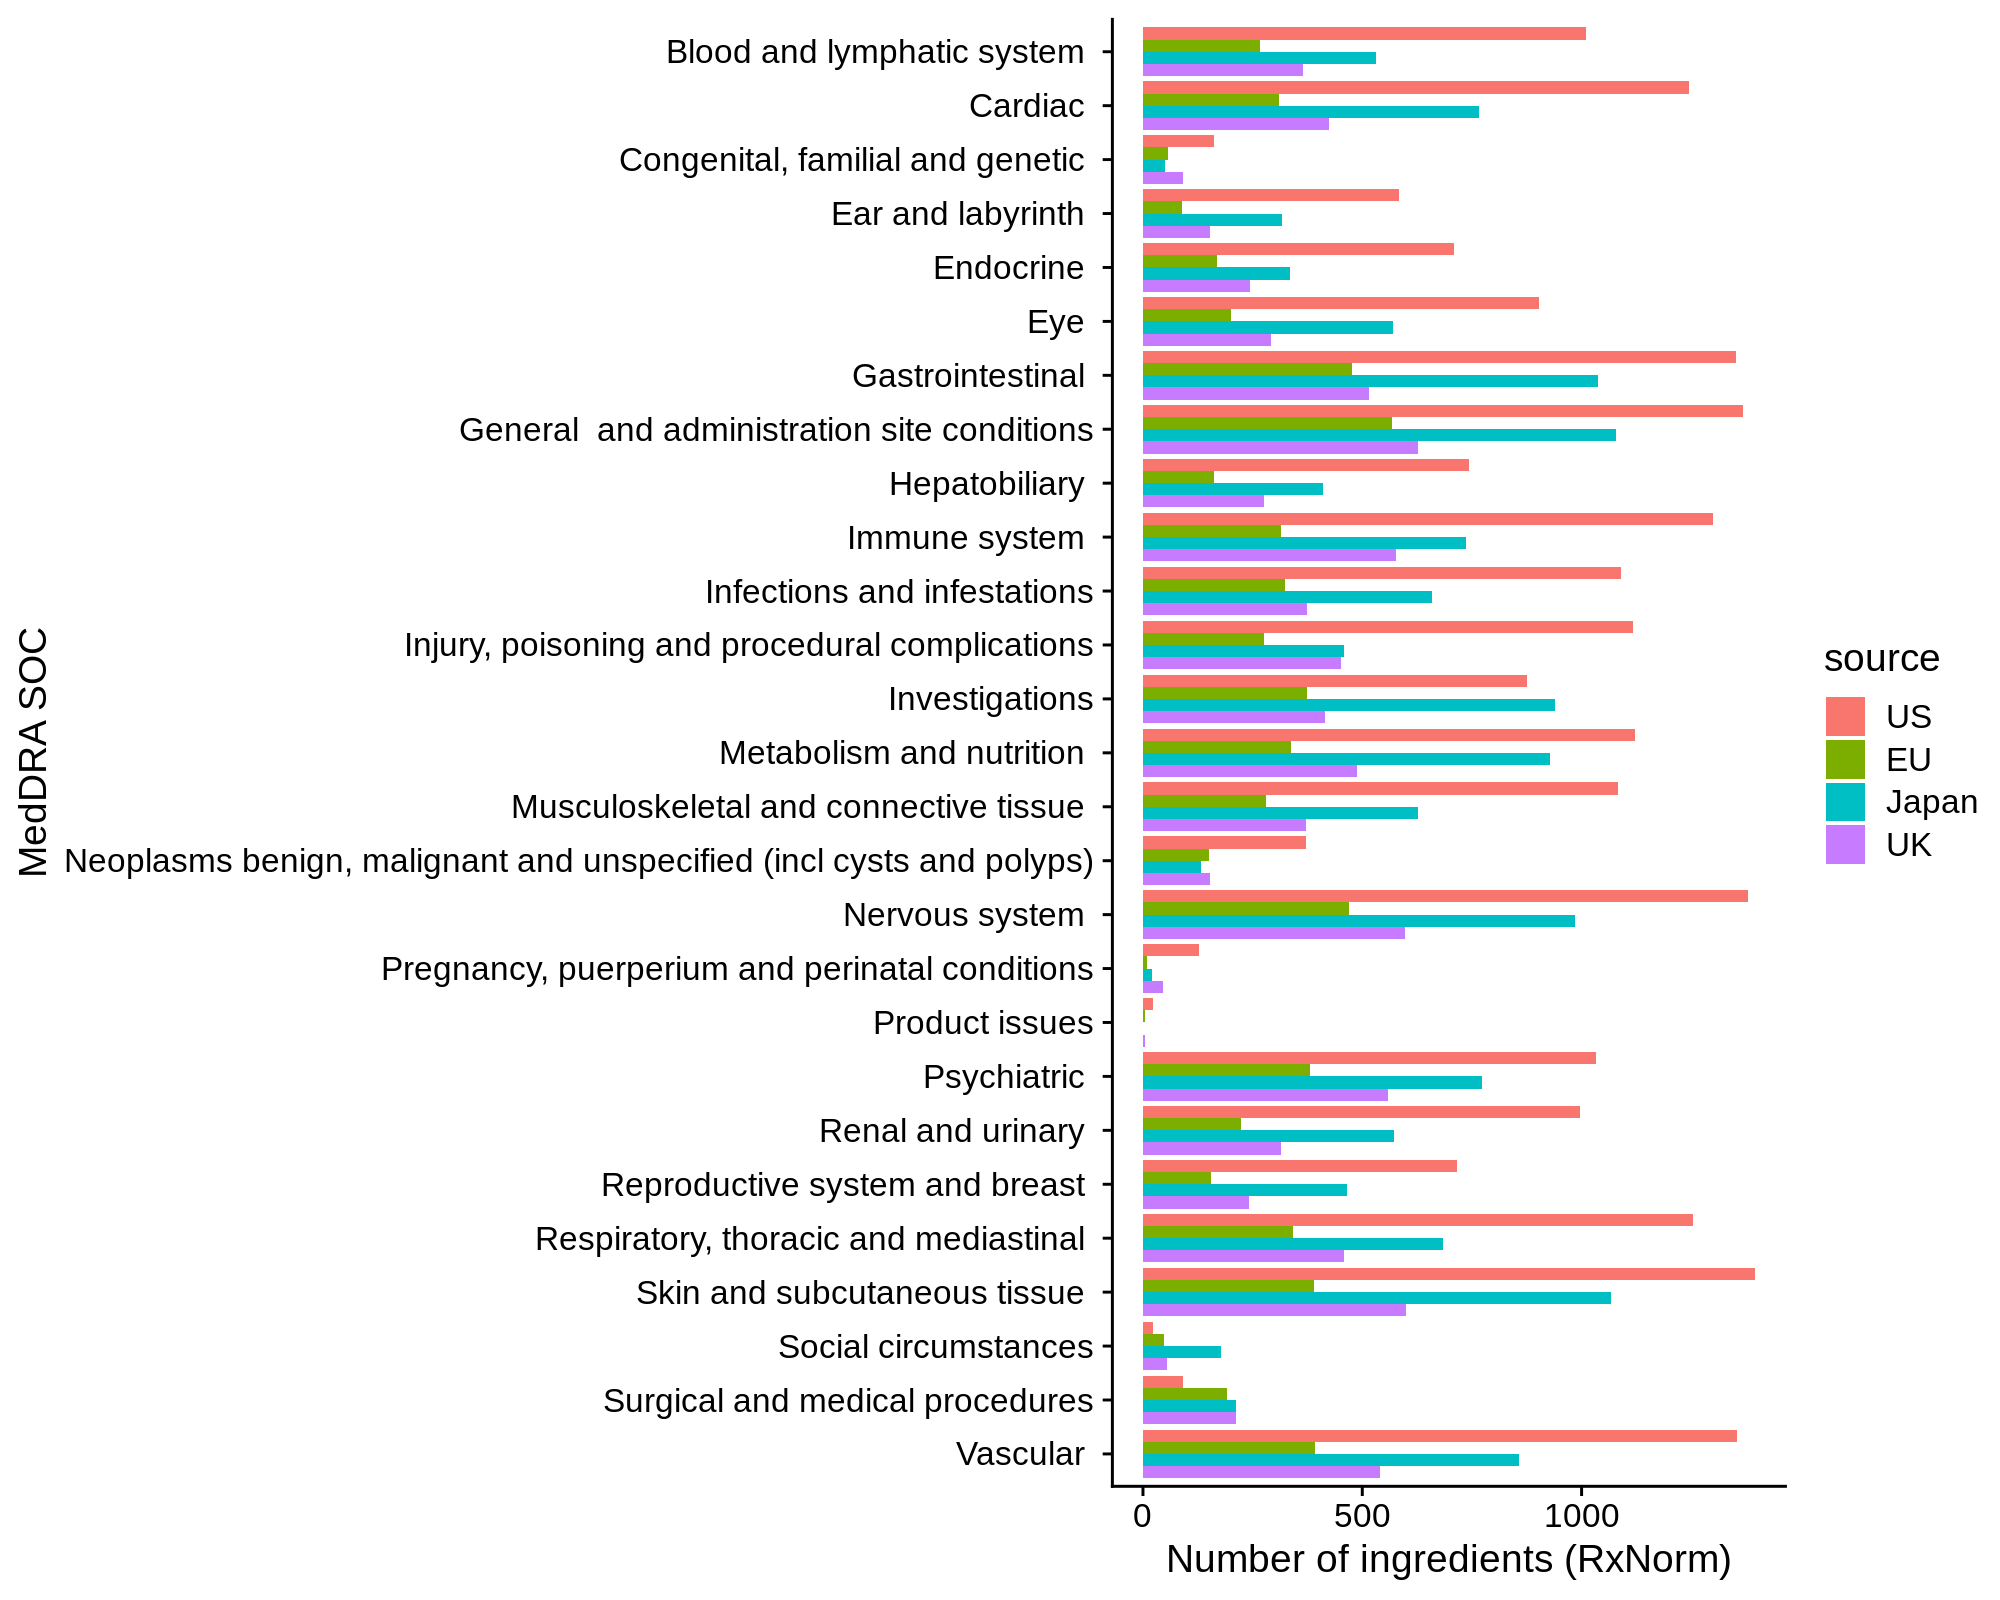

In [12]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 200)

fig_b <- fig_b_df %>%
    mutate(meddra_soc_concept_name = meddra_soc_concept_name %>% fct_rev) %>%
    ggplot(aes(y = meddra_soc_concept_name, x = n_ingredients, fill = source)) +
    geom_col(position = position_dodge2(reverse = T, padding = 0)) +
    xlab("Number of ingredients (RxNorm)") +
    ylab("MedDRA SOC") +
    theme_cowplot()

fig_b

# Heatmaps

In [13]:
heatmap_df <- plot_df %>%
    mutate(ingredient_adr_combo = str_c(atc_5_concept_id, "_", meddra_pt_concept_id)) %>%
    select(source, meddra_soc_concept_name, atc_1_concept_name, ingredient_adr_combo) %>%
    distinct %>%
    chop(ingredient_adr_combo) %>%
    pivot_wider(id_cols = c(meddra_soc_concept_name, atc_1_concept_name), names_from = source, 
                values_from = ingredient_adr_combo) %>%
    pivot_longer(c(UK, Japan, EU), names_to = "other_source", values_to = "other_source_combo") %>%
    rename(US_combo = US) %>%
    rowwise() %>%
    mutate(
        intersection = length(intersect(US_combo, other_source_combo)),
        union = length(union(US_combo, other_source_combo)),
        jaccard = intersection / union
    ) %>%
    ungroup %>%
    select(meddra_soc_concept_name, atc_1_concept_name, other_source, intersection, union, jaccard) %>%
    complete(meddra_soc_concept_name, atc_1_concept_name, other_source) %>%
    mutate(
        across(c(intersection, union, jaccard), ~replace_na(., 0.))
    )

heatmap_df %>% head(2)

meddra_soc_concept_name,atc_1_concept_name,other_source,intersection,union,jaccard
<chr>,<fct>,<chr>,<int>,<int>,<dbl>
Blood and lymphatic system,Alimentary tract and metabolism,EU,314,2970,0.1057239
Blood and lymphatic system,Alimentary tract and metabolism,Japan,424,3057,0.1386981


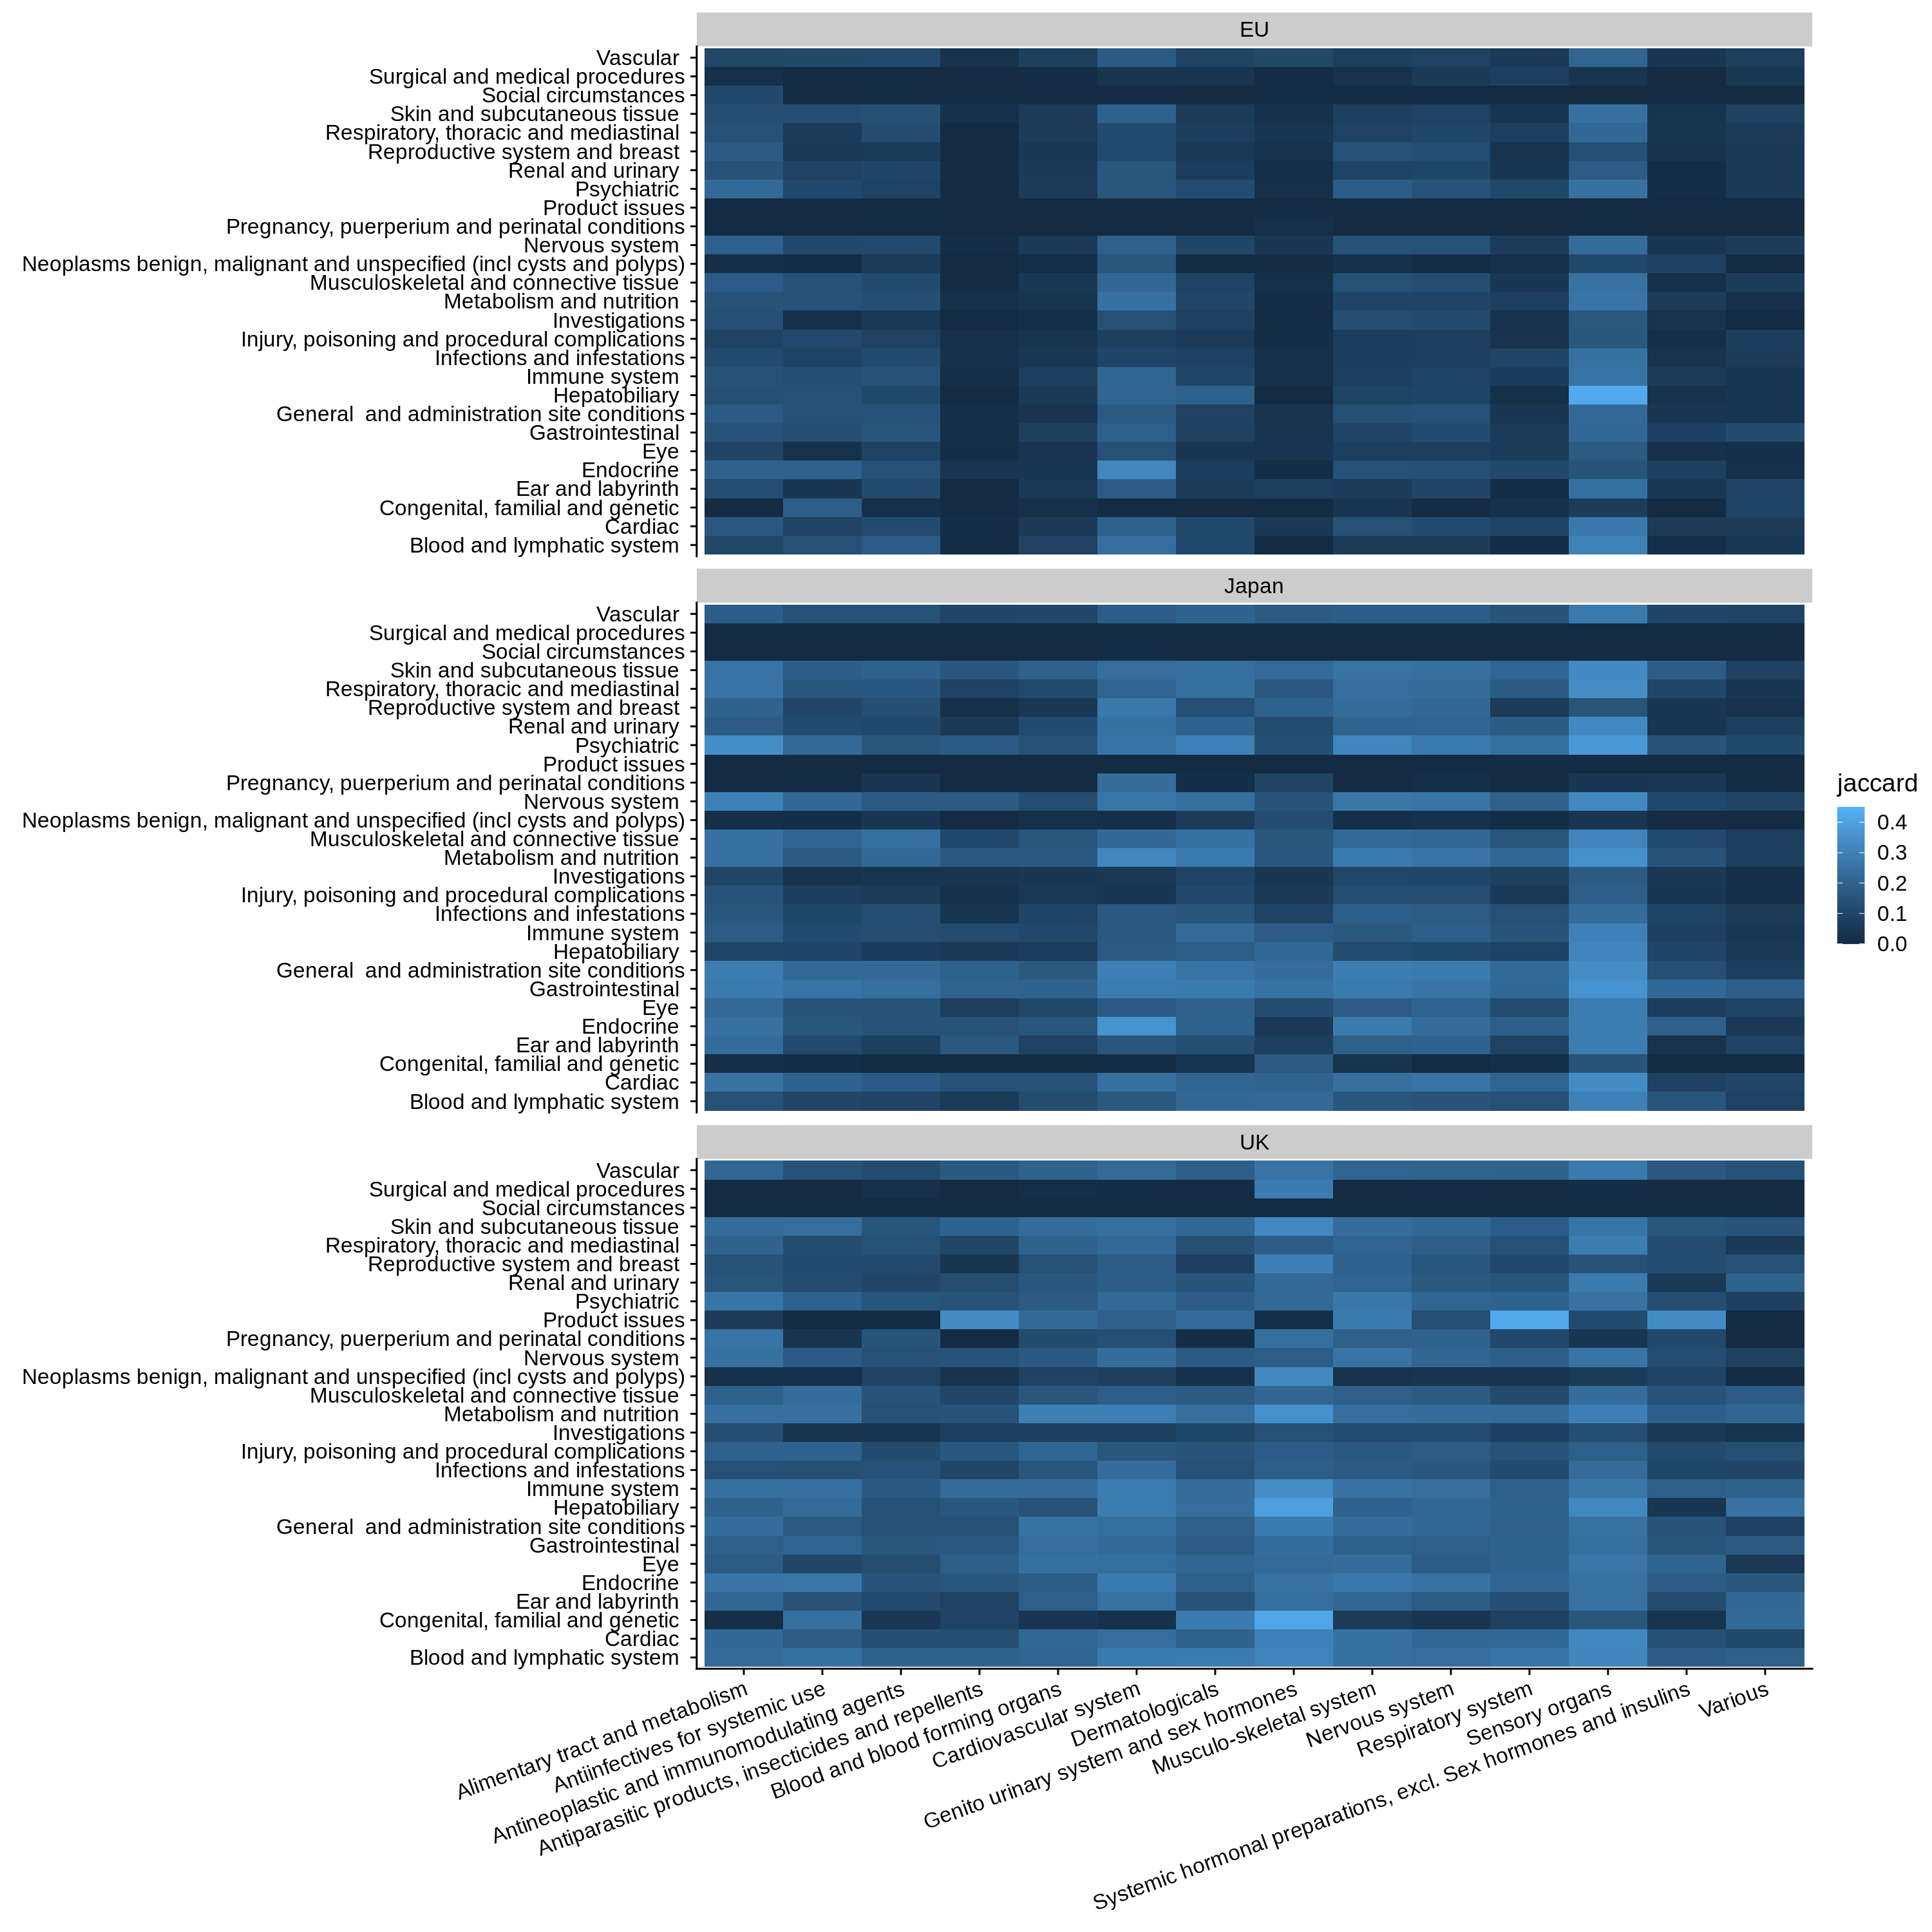

In [14]:
options(repr.plot.width = 15, repr.plot.height = 15, repr.plot.res = 200)

heatmap <- heatmap_df %>%
    ggplot(aes(y = meddra_soc_concept_name, x = atc_1_concept_name, fill = jaccard)) +
    geom_tile() +
    facet_wrap(vars(other_source), ncol = 1) +
    theme_cowplot() +
    theme(
        axis.text.x = element_text(angle=20, hjust=1),
        axis.title.x = element_blank(),
        axis.title.y = element_blank()
    ) +
    ylab("MedDRA SOC") +
    xlab("ATC 1 class") +
    scale_fill_continuous(limits = c(0., 0.45))

heatmap

# Scatterplots

In [15]:
scatterplot_df <- plot_df %>%
    group_by(source, rxnorm_concept_code) %>%
    summarize(
        n_adrs = n_distinct(meddra_pt_concept_code),
        .groups = "drop"
    ) %>%
    pivot_wider(id_cols = rxnorm_concept_code, names_from = source, values_from = n_adrs) %>%
    pivot_longer(c(UK, Japan, EU), names_to = "other_source", values_to = "other_n_adrs") %>%
    rename(US_n_adrs = US) %>%
    mutate(across(c(US_n_adrs, other_n_adrs), ~replace_na(., 0.)))

scatterplot_df %>% head(2)

rxnorm_concept_code,US_n_adrs,other_source,other_n_adrs
<chr>,<int>,<chr>,<int>
1000082,15,UK,0
1000082,15,Japan,0


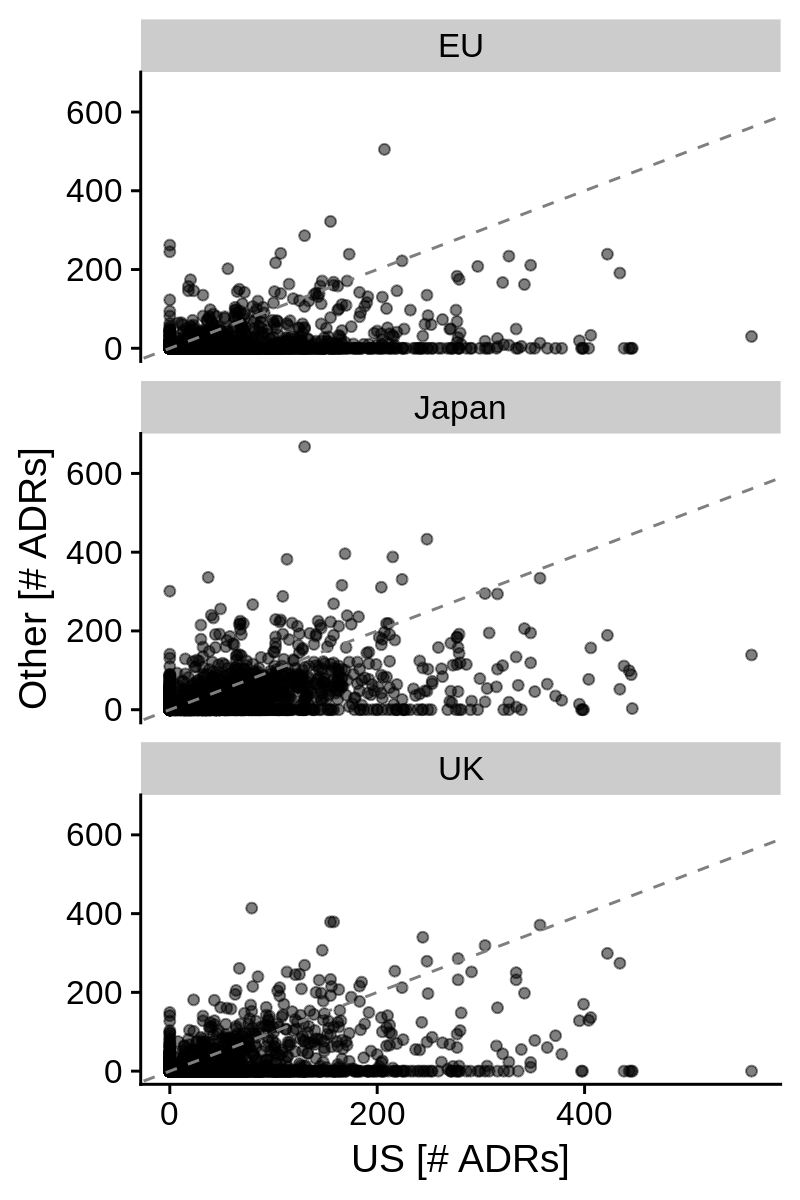

In [16]:
options(repr.plot.width = 4, repr.plot.height = 6, repr.plot.res = 200)

scatterplot <- scatterplot_df %>%
    ggplot(aes(x = US_n_adrs, y = other_n_adrs)) +
    geom_point(alpha = 0.5) +
    geom_abline(linetype = "dashed", color = "grey50") +
    facet_wrap(vars(other_source), ncol = 1) +
    xlab("US [# ADRs]") +
    ylab("Other [# ADRs]") +
    theme_cowplot()

scatterplot

# Full figure

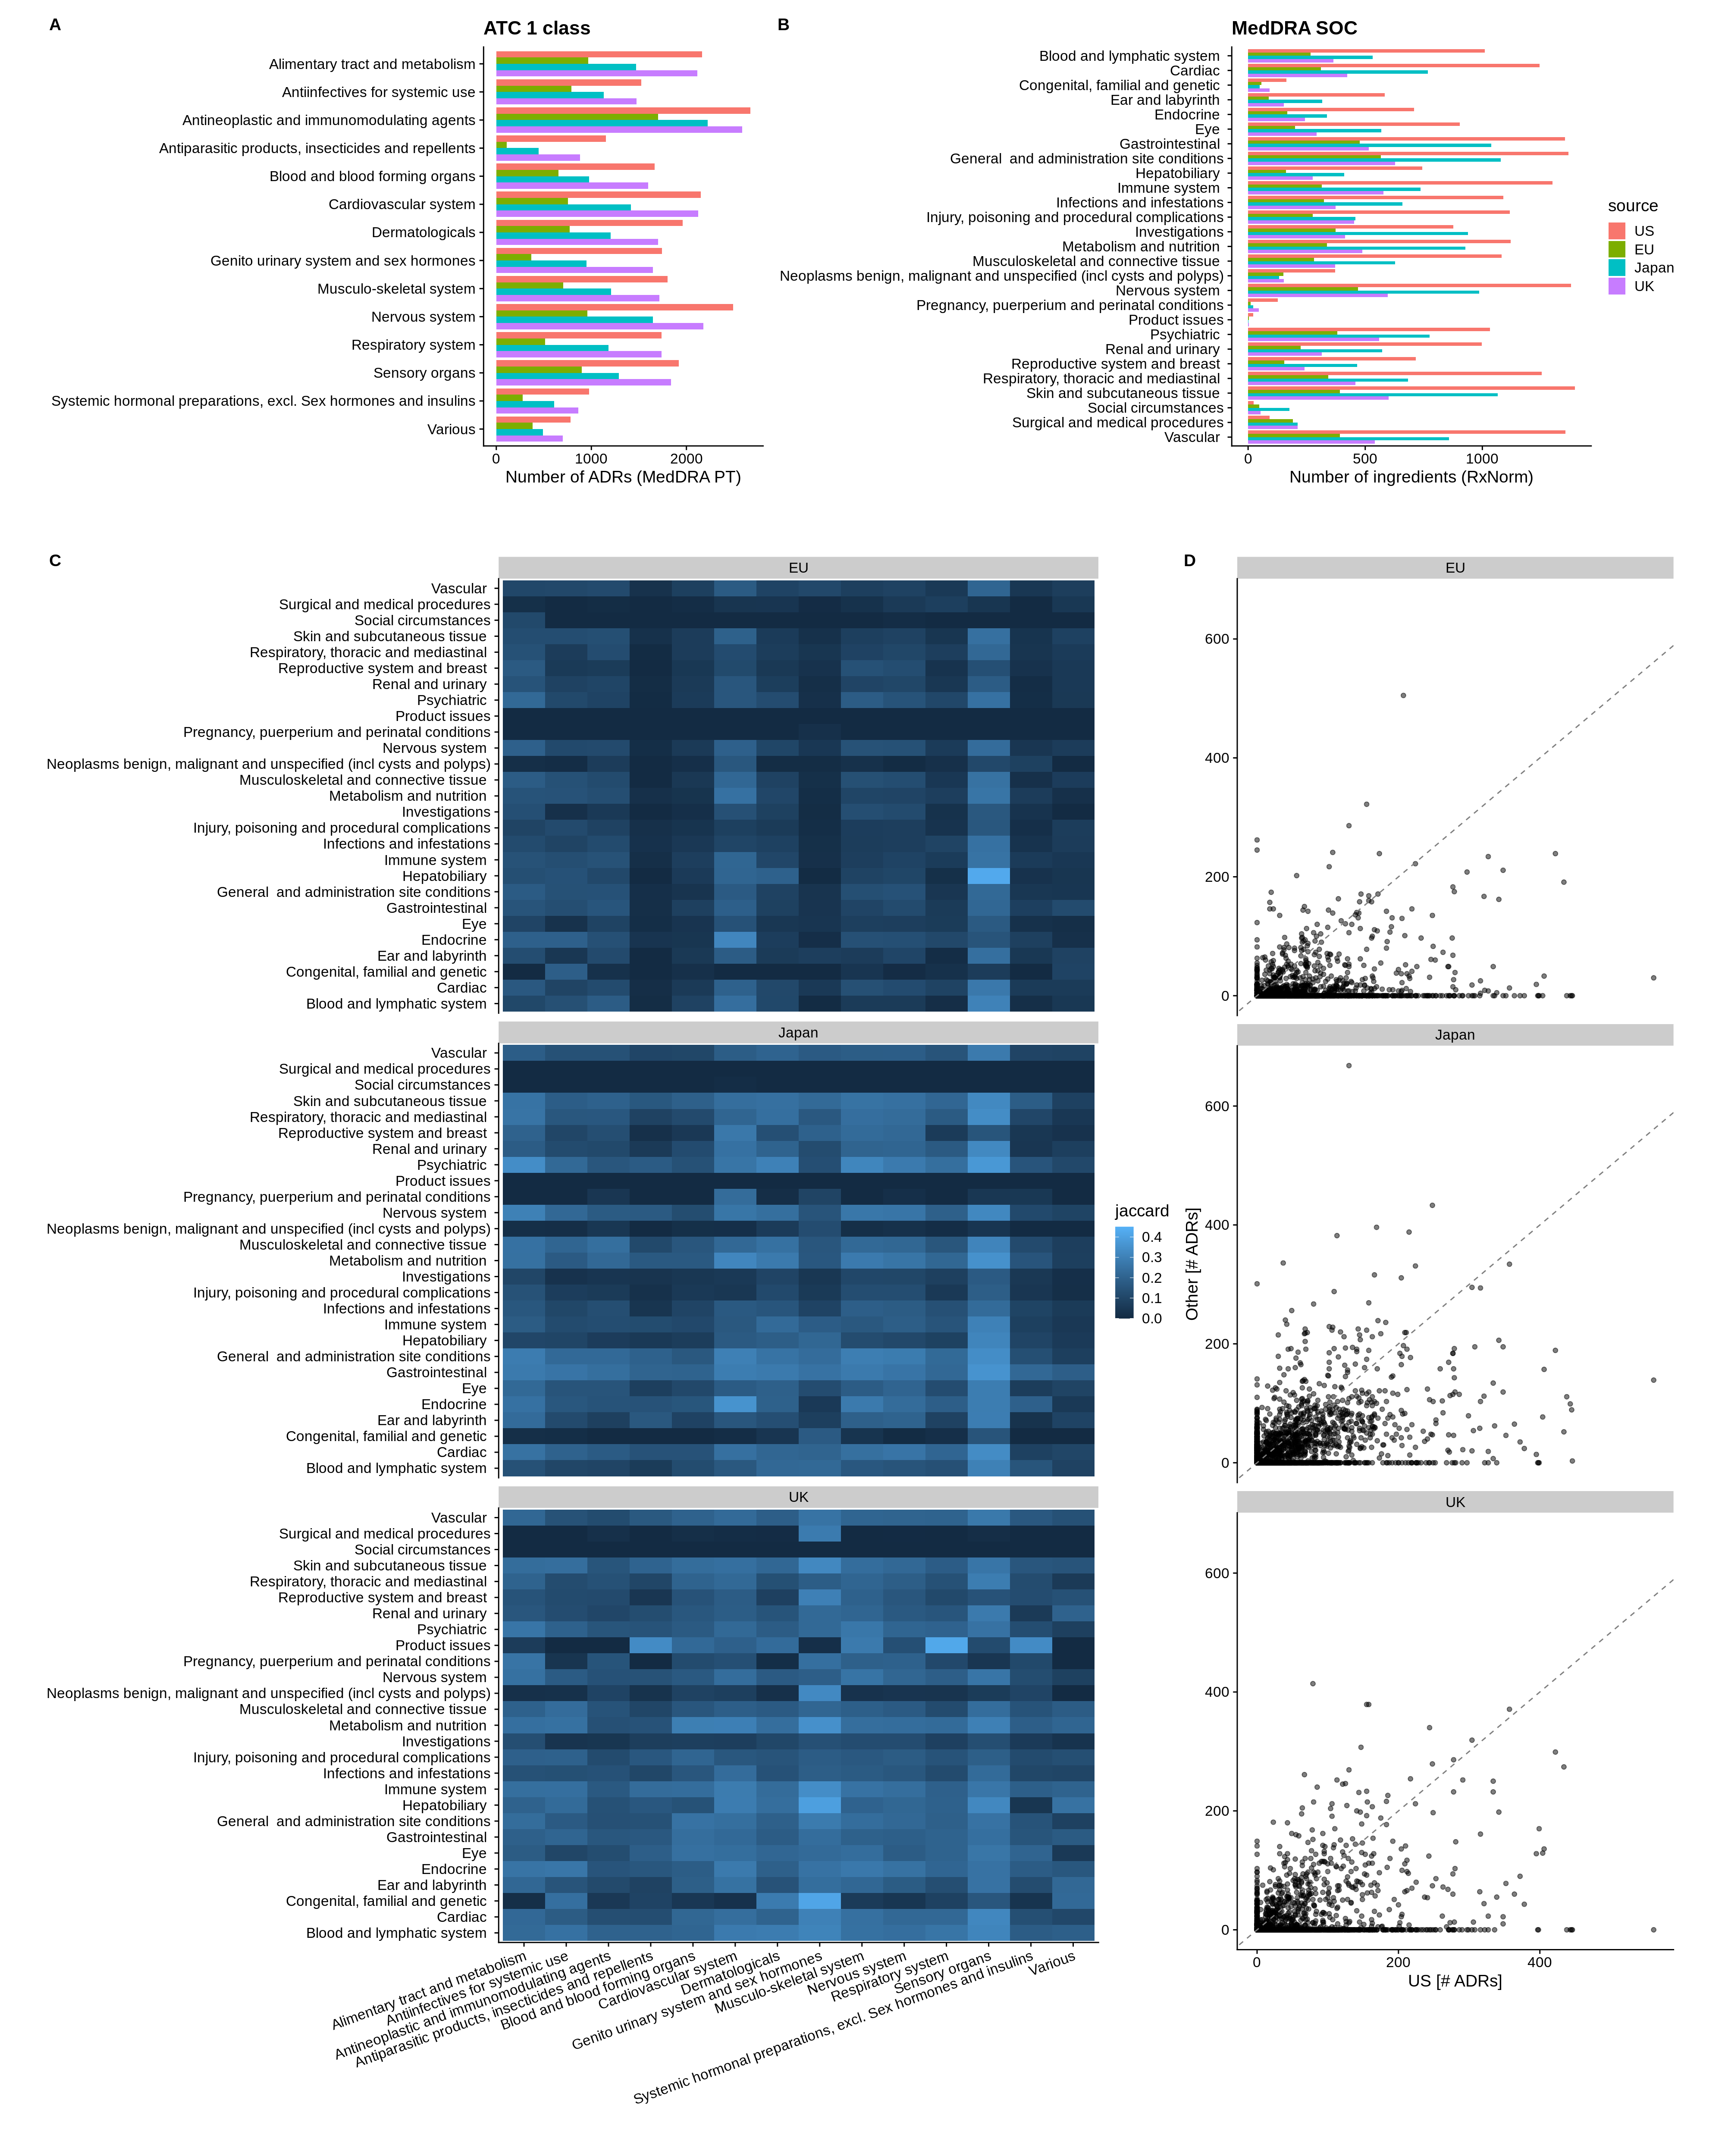

In [17]:
options(repr.plot.width = 20, repr.plot.height = 25, repr.plot.res = 200)

full_plot <- plot_grid(
    plot_grid(
        fig_a + ggtitle("ATC 1 class") + theme(axis.title.y = element_blank(), legend.position = "none"), 
        fig_b + ggtitle("MedDRA SOC") + theme(axis.title.y = element_blank()), 
        ncol = 2, labels = c("A", "B"), rel_widths = c(1, 1.25)), 
    plot_grid(
        heatmap, 
        plot_grid(scatterplot, NULL, ncol = 1, rel_heights = c(1, 0.08)), 
        ncol = 2, labels = c("C", "D"), rel_widths = c(2.25, 1)
    ),
    # scatterplot,
    # heatmap,
    # labels = c("", ""),
    ncol = 1,
    rel_heights = c(1, 3.25),
    scale = 0.95
)

full_plot

In [18]:
save_plot("full_plot.png", full_plot, base_height = 25, base_width = 20, dpi = 400, scale = 1.2)